## Load data

In [1]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
random_state = 12041500

In [2]:
df_train = pd.read_csv("./data2/synthetic_data_DataSynthesizer_correlated_attribute_mode.csv")
df_test = pd.read_json("./data2/testset.json")

ratio_features = ["age", "capital-gain", "capital-loss", "hours-per-week"]
ordinal_features = ["education-num"]
nominal_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
target = 'income'

## Train baseline

In [3]:
from sklearn.linear_model import LogisticRegression
from utils import create_model, train_and_evaluate, describe_model

In [4]:
clf = LogisticRegression(max_iter=1000, random_state=random_state)

In [5]:
## Train baseline
model = create_model(clf, nominal_features)
y_test, y_pred = train_and_evaluate(model, df_train, df_test, target, drop_na=True)
metrics = describe_model(y_test, y_pred, verbose=True)

Metric         Value               
Accuracy       0.8144663948991324
Precision      0.7564746195561247
Recall         0.6894306177151284
F1             0.710794506680759


## Fairness Evaluation

In [6]:
from utils import split_data
from utils_fairness import search_bias, calc_fairness_score, explain_detected_bias

In [7]:
X_train, y_train = split_data(df_train, target, drop_na=True)

In [8]:
model = create_model(clf, nominal_features)
model.fit(X_train, y_train)
probs = pd.Series(model.predict_proba(X_train)[:, 1]) # we select for target label

In [9]:
privileged_subset, _ = search_bias(X_train, y_train, probs, 1, penalty=25)

In [10]:
print(privileged_subset)

({'age': [20.0, 21.0, 22.0, 23.0, 24.0]}, 51.026)


In [11]:
calc_fairness_score(df_train, privileged_subset[0].keys(), target, verbose=True)

Sensitive Attributes: ['age']

             Group Distance  Proportion  Counts   P-Value
age [17.00, 22.00]   -0.248    0.120628    4590 4.94e-324
age [22.00, 26.00]   -0.204    0.089091    3390 1.57e-207
age [46.00, 53.00]    0.158    0.116659    4439 3.70e-114
age [42.00, 46.00]    0.121    0.091956    3499  7.77e-55
age [38.00, 42.00]    0.113    0.098972    3766  5.77e-52
age [26.00, 30.00]   -0.101    0.096371    3667  2.66e-47
age [61.00, 90.00]    0.105    0.097448    3708  4.18e-44
age [53.00, 61.00]    0.089    0.085044    3236  6.69e-29
age [30.00, 34.00]   -0.034    0.115214    4384  1.86e-07
age [34.00, 38.00]    0.036    0.088618    3372  2.40e-06

Weighted Mean Statistical Distance: 0.12361860578392513


In [12]:
explain_detected_bias(df_train, probs, target, privileged_subset[0])

Our detected privileged group has a size of 4739, we observe 0.0198 as the average probability of earning >50k, but our model predicts 0.2683


## Fairness Metrics

In [13]:
from utils_fairness import transform_to_bias_dataset, describe_fairness, scan_and_calculate_fairness, plot_fairness_metrics

In [14]:
df_train_bias = transform_to_bias_dataset(df_train, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), verbose=True)
df_test_bias = transform_to_bias_dataset(df_test, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), verbose=True)

1022 Na rows removed!
202 Na rows removed!


In [15]:
model = create_model(clf, nominal_features)
y_test, y_pred = train_and_evaluate(model, df_train, df_train, target, drop_na=True)
metrics = describe_fairness(df_train_bias[target], y_pred, list(privileged_subset[0].keys()), verbose=True)

Metric                          Value               
statistical_parity_difference   0.2023089808361361
average_odds_difference         0.16896200212706
equal_opportunity_difference    0.25190124743869285
disparate_impact                10.02730170798914
theil_index                     0.16603371546509008


In [16]:
df_fairness_metrics, priviliged_subsets = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "average_abs_odds_difference",
        "equal_opportunity_difference",
        "disparate_impact",
        "theil_index",
    ]
), {}

for i in [0.001, 0.01, 0.1, 1, 5, 25, 50, 100]:
    metrics, priv = scan_and_calculate_fairness(model, df_train, target, i)    
    df_fairness_metrics.loc[f"penalty_{i}"] = metrics.values()
    priviliged_subsets[f"penalty_{i}"] = priv

In [17]:
df_fairness_metrics

,statistical_parity_difference,average_abs_odds_difference,equal_opportunity_difference,disparate_impact,theil_index
penalty_0.001,0.127370,0.253466,0.504884,2.447705,0.166034
penalty_0.01,0.151786,0.264823,0.504884,3.179710,0.166034
penalty_0.1,0.108631,-0.261179,-0.495214,1.981812,0.166034
penalty_1,0.132048,-0.025097,-0.081797,2.346142,0.166034
penalty_5,0.150249,0.004117,-0.035875,2.786224,0.166034
penalty_25,0.202309,0.168962,0.251901,10.027302,0.166034
penalty_50,0.000000,0.000000,0.000000,1.000000,0.000000
penalty_100,0.000000,0.000000,0.000000,1.000000,0.000000


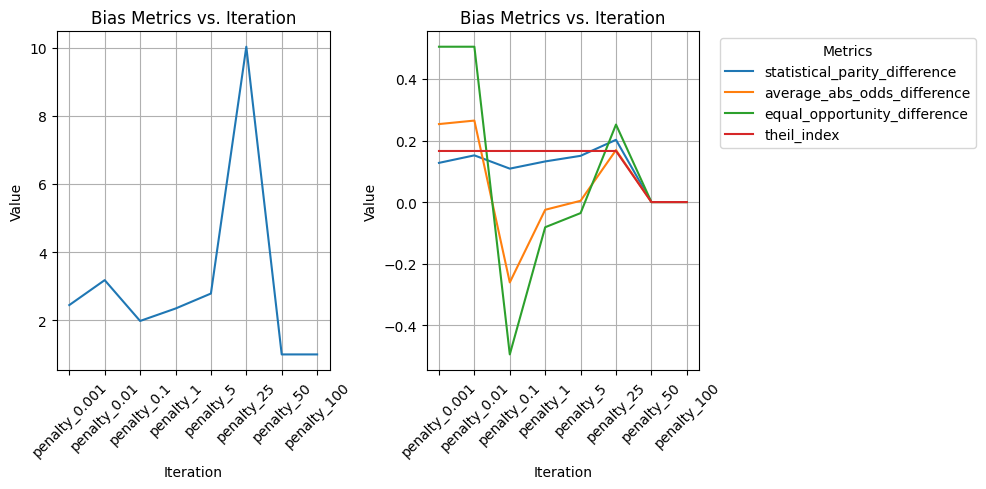

In [18]:
plot_fairness_metrics(df_fairness_metrics)

## Mitigation

In [19]:
from tqdm import tqdm
from sklearn import clone
from aif360.algorithms.preprocessing import Reweighing
from utils_fairness import create_aif360_standardDataset, compute_metrics, reweight_mitigation
from utils import plot_metrics

### Reweighting

In [20]:
# create (un)privileged groups
privileged_groups = [{key: 1 for key in list(privileged_subset[0].keys())}]
unprivileged_groups = [{key: 0 for key in list(privileged_subset[0].keys())}]

# convert dataset
train_dataset = create_aif360_standardDataset(df_train, nominal_features, target, 1, list(privileged_subset[0].keys()), list(privileged_subset[0].values()))
test_dataset = create_aif360_standardDataset(df_test, nominal_features, target, 1, list(privileged_subset[0].keys()), list(privileged_subset[0].values()))

# train model
model = clone(clf)
model.fit(train_dataset.features, train_dataset.labels.ravel())
y_pred = model.predict(train_dataset.features)

# model = create_model(clf, nominal_features)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_train)

# compare results
train_dataset_prediction = train_dataset.copy()
train_dataset_prediction.labels = y_pred.reshape(-1, 1)
train_dataset_prediction.scores = y_pred.reshape(-1, 1)
_ = compute_metrics(train_dataset, train_dataset_prediction, unprivileged_groups, privileged_groups)

Statistical parity difference = 0.2191
Disparate impact = 112.8794
Average odds difference = 0.2694
Equal opportunity difference = 0.4395
Theil index = 0.1665


In [21]:
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
RW.fit(train_dataset)

train_dataset_reweight = RW.transform(train_dataset)

In [22]:
model = create_model(clf, nominal_features)

# original model
y_test, y_pred = train_and_evaluate(model, df_train, df_test, target, drop_na=True, sample_weight=None)
_ = describe_model(y_test, y_pred, verbose=True)

# mitigated model
y_test, y_pred = train_and_evaluate(model, df_train, df_test, target, drop_na=True, sample_weight=train_dataset_reweight.instance_weights)
_ = describe_model(y_test, y_pred, verbose=True)

Metric         Value               
Accuracy       0.8144663948991324
Precision      0.7564746195561247
Recall         0.6894306177151284
F1             0.710794506680759
Metric         Value               
Accuracy       0.8158252325702937
Precision      0.7625818322944362
Recall         0.6845343513806333
F1             0.7076814554139434


In [23]:
def check_for_equality(standart_dataset, column_name):
    df, _ = standart_dataset.convert_to_dataframe()
    df1_aligned, df2_aligned = df[column_name].align((df_train.dropna())[column_name], join='inner')

    if df1_aligned.equals(df2_aligned):
        print(f"Column '{column_name}' is the same in both DataFrames.")
    else:
        print(f"Column '{column_name}' differs in the DataFrames. Differences are at the following indices:")
        # Identify the indices where they differ
        differences = df1_aligned != df2_aligned
        differing_indices = differences[differences].index
        
        # Print the differing values and their indices
        for idx in differing_indices:
            print(f"Index {idx}: df1[{column_name}] = {df1_aligned.at[idx]}, df2[{column_name}] = {df2_aligned.at[idx]}")

In [24]:
for col in list(privileged_subset[0].keys()):
    check_for_equality(train_dataset_reweight, col)

Column 'age' is the same in both DataFrames.


In [25]:
df_fairness_metrics = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "average_abs_odds_difference",
        "equal_opportunity_difference",
        "disparate_impact",
        "theil_index",
    ]
)

df_metrics = pd.DataFrame(
    columns=['acc', 'prec', 'rec', 'f1']
)

weights = None

weights_hist = [weights]
max_iter = 10
for i in tqdm(range(max_iter)):
    X_train, y_train = split_data(df_train, target, True)
    X_test, y_test = split_data(df_test, target, True)
    weights, model_metrics, fair_metrics = reweight_mitigation(clf, nominal_features, target, X_train, y_train, X_test, y_test, penalty=20, sample_weights=weights)
    if model_metrics is None and fair_metrics is None and weights is None:
        break

    df_metrics.loc[f"mitigation_{i}"] = model_metrics.values()
    df_fairness_metrics.loc[f"mitigation_{i}"] = fair_metrics.values()
    weights_hist.append(weights)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [10:32<00:00, 63.21s/it]


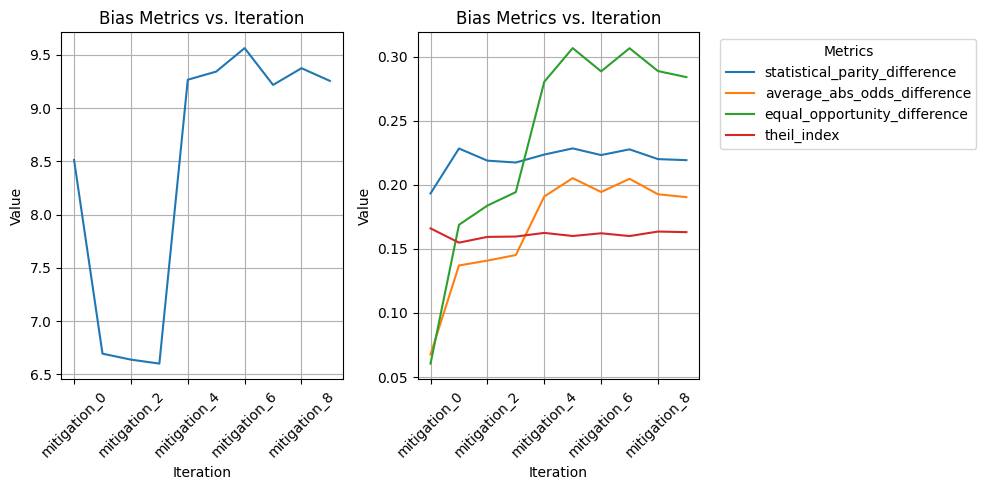

In [26]:
plot_fairness_metrics(df_fairness_metrics)

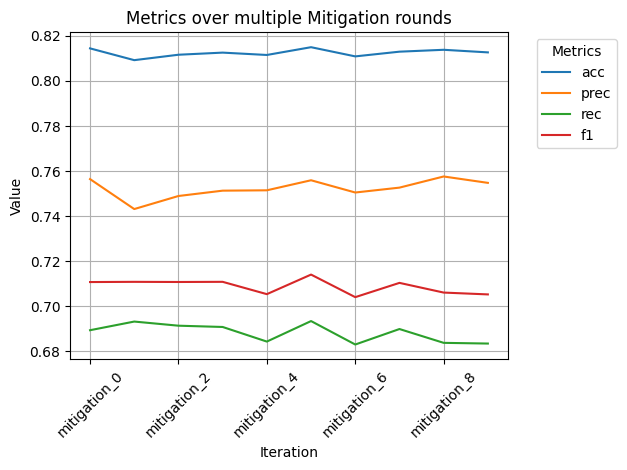

In [27]:
plot_metrics(df_metrics, 'Iteration', 'Value', 'Metrics over multiple Mitigation rounds')

### Fair Learning

In [28]:
from utils import prepare_data_fair_learning, plot_fairlearning_results
from utils_fairness import get_fair_learning_scoring

In [39]:
df_train_bias = transform_to_bias_dataset(df_train, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), verbose=True)
df_test_bias = transform_to_bias_dataset(df_test, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), verbose=True)

X_train, y_train, X_test, y_test = prepare_data_fair_learning(df_train_bias, df_test_bias, nominal_features, target)

1022 Na rows removed!
202 Na rows removed!


In [44]:
max_delta = get_fair_learning_scoring(list(privileged_subset[0].keys()))

In [45]:
from sklearn.model_selection import GridSearchCV
from aif360.sklearn.preprocessing import LearnedFairRepresentations

lfr = LearnedFairRepresentations(list(privileged_subset[0].keys()), n_prototypes=25, max_iter=100, random_state=random_state)
params = {
    "reconstruct_weight": [1e-2, 1e-3, 1e-4],
    "target_weight": [100, 1000],
    "fairness_weight": [0, 100, 1000],
}

grid = GridSearchCV(lfr, params, scoring=max_delta, cv=3, n_jobs=-1).fit(X_train, y_train, priv_group=(1,)*len(list(privileged_subset[0].keys())))
res = pd.DataFrame(grid.cv_results_)
display(res)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/sklearn/preprocessing/learning_fair_representations.py:163: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn('lbfgs failed to converge. Increase the number of '
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/sklearn/preprocessing/learning_fair_representations.py:163: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn('lbfgs failed to converge. Increase the number of '
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/sklearn/preprocessing/learning_fair_representations.py:163: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn('lbfgs failed to converge. Increase the number of '
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fairness_weight,param_reconstruct_weight,param_target_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,4.827867,1.326434,0.114997,0.011422,0,0.0100,100,"{'fairness_weight': 0, 'reconstruct_weight': 0...",-0.284828,-0.279285,-0.286314,-0.283476,0.003025,1
1,2.826416,0.089887,0.118861,0.042119,0,0.0100,1000,"{'fairness_weight': 0, 'reconstruct_weight': 0...",-0.712633,-0.723573,-0.725862,-0.720689,0.005773,4
2,2.408081,0.333028,0.118992,0.029836,0,0.0010,100,"{'fairness_weight': 0, 'reconstruct_weight': 0...",-0.719510,-0.724073,-0.721772,-0.721785,0.001863,6
3,2.029728,0.216182,0.118018,0.020520,0,0.0010,1000,"{'fairness_weight': 0, 'reconstruct_weight': 0...",-0.733680,-0.733096,-0.733659,-0.733478,0.000271,11
4,1.704040,0.143466,0.104057,0.010259,0,0.0001,100,"{'fairness_weight': 0, 'reconstruct_weight': 0...",-0.733680,-0.733601,-0.733659,-0.733647,0.000033,15
5,1.757569,0.055767,0.083743,0.014415,0,0.0001,1000,"{'fairness_weight': 0, 'reconstruct_weight': 0...",-0.733680,-0.720207,-0.733659,-0.729182,0.006346,9
6,5.873725,2.046938,0.099575,0.018443,100,0.0100,100,"{'fairness_weight': 100, 'reconstruct_weight':...",-0.722023,-0.721745,-0.271127,-0.571631,0.212489,3
7,2.136136,0.177208,0.133496,0.004581,100,0.0100,1000,"{'fairness_weight': 100, 'reconstruct_weight':...",-0.728928,-0.715222,-0.726258,-0.723469,0.005933,7
8,2.813373,0.566302,0.400522,0.319104,100,0.0010,100,"{'fairness_weight': 100, 'reconstruct_weight':...",-0.733680,-0.720492,-0.726568,-0.726913,0.005390,8
9,3.428156,0.932706,0.137801,0.039610,100,0.0010,1000,"{'fairness_weight': 100, 'reconstruct_weight':...",-0.733680,-0.733096,-0.733659,-0.733478,0.000271,11


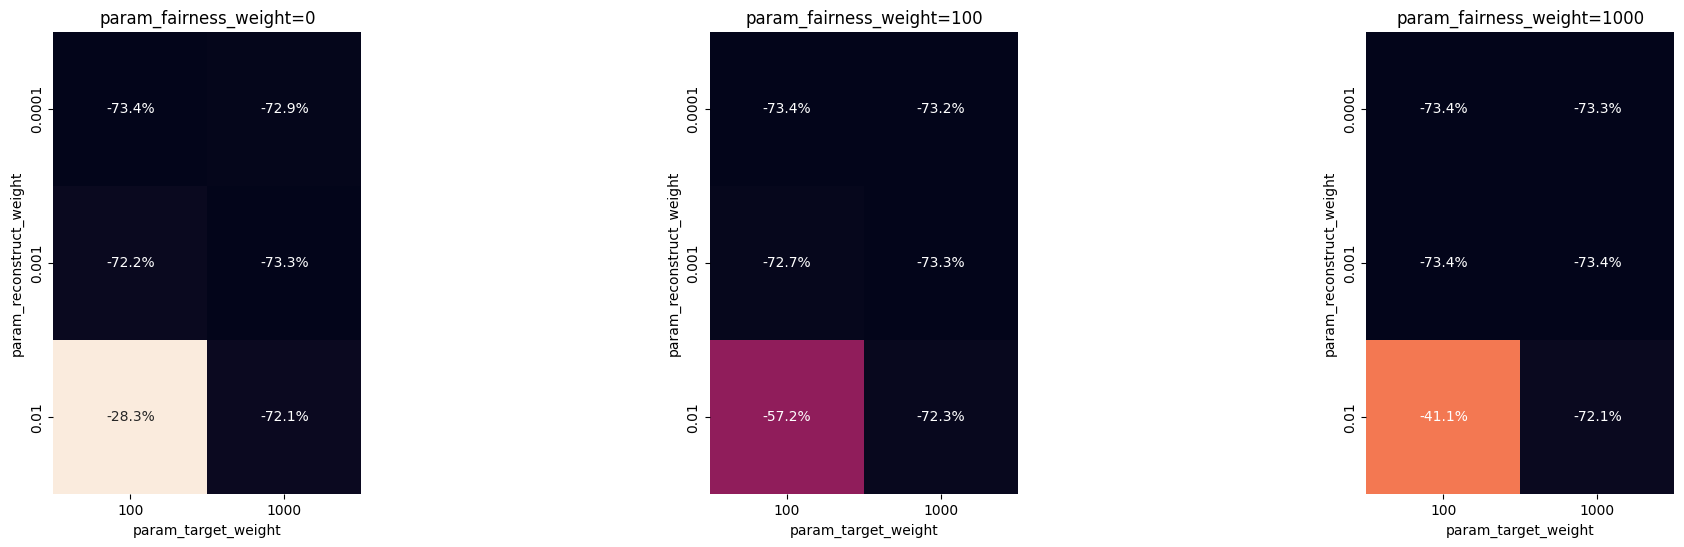

In [49]:
plot_fairlearning_results(res)

In [50]:
model = create_model(clf, [])

In [56]:
model.fit(X_train, y_train)

_ = describe_model(y_test, model.predict(X_test), verbose=True)
_ = describe_fairness(y_train, model.predict(X_train), list(privileged_subset[0].keys()) ,verbose=True)

Metric         Value               
Accuracy       0.8140482910003136
Precision      0.7552986999400467
Recall         0.6897492958039642
F1             0.7108191097917141
Metric                          Value               
statistical_parity_difference   0.2041107789466619
average_odds_difference         0.17603865657448137
equal_opportunity_difference    0.2647305621420263
disparate_impact                10.196991569008413
theil_index                     0.16563633704736633


In [55]:
_ = describe_model(y_test, grid.predict(X_test), verbose=True)
_ = describe_fairness(y_train, grid.predict(X_train), list(privileged_subset[0].keys()) ,verbose=True)

Metric         Value               
Accuracy       0.23884185220027176
Precision      0.3544111471120489
Recall         0.4657872335691479
F1             0.2085722074247166
Metric                          Value               
statistical_parity_difference   -0.0049563674832293625
average_odds_difference         -0.0062809426898944865
equal_opportunity_difference    -0.007957798557827744
disparate_impact                0.9947524844614324
theil_index                     0.05643877604764516


In [61]:
model.fit(grid.transform(X_train), y_train)

_ = describe_model(y_test, model.predict(X_test), verbose=True)
_ = describe_fairness(y_train, model.predict(X_train), list(privileged_subset[0].keys()) ,verbose=True)
_ = describe_fairness(y_train, model.predict(grid.transform(X_train)), list(privileged_subset[0].keys()) ,verbose=True)

Metric         Value               
Accuracy       0.7947109856799415
Precision      0.7377446095546342
Recall         0.6238617934757839
F1             0.6421199912842213
Metric                          Value               
statistical_parity_difference   -0.13852971900604572
average_odds_difference         -0.1813039578271299
equal_opportunity_difference    -0.21164925931341083
disparate_impact                0.8189184901729846
theil_index                     0.15010534535815823
Metric                          Value               
statistical_parity_difference               0.0
average_odds_difference                     0.0
equal_opportunity_difference                0.0
disparate_impact                            0.0
theil_index                     0.30972736401638046


Multiple Runs cannot be done, because of the dataset already needs to be one hot encoded for the mitigation, making the `search_bias` function unnecessary and returning not viable resolutions.

### Fair Adapt